# Linear Regression - some Theory
For linear regression the closed solution is known via the so called normal equation
Todo:
1. Specify model
2. Speficy loss function
2. Write down log Likelihood function
3. Minimize + get Normal equation

### Approach 1: Non-probabilisitc using loss function
The easies approach to linear regression is to use the squared loss function, 
$$l = \sum_{i=1}^N (y_i - \hat y_i)^2,$$
where $\hat y_i$ is the predicted value and $y_i$ is the true value of sample $i$. Together with a linear, non probabilistic model for the. For feature vector $x_i$ (where the first component is per convention the constant one -aka known as intercept) the prediction is given by the linear model. In scalar product notation:
$$y_i =  x_i^T \theta,$$
with coefficient vector $\theta$. Rewriting this in Matrix notation to account for all sampels we get for the loss together with the linear model:
$$l = (Y - X\theta)^T (Y - X\theta)$$
Now we would like to find $\theta^*$ that _minimizes_ the loss. 
Setting the derivative w.r.t. $\theta$ of the loss function zero  gives the normal equation 
$$X^T(Y - X\theta) = 0.$$
If $X^T X$ is non-singular (this is the case when there are more traning examples than features because then $X^T X$ is positive definite) allows for finding the unique solutions of the normal equation, 

$$\theta ^* =  \left( X^T X  \right)^{-1} X^T Y$$

Note that this approach is non-probabilistic and thus, does not explicitly account for uncertainty  (as a probability distributions) in the data and coefficients.
### Approach 2: Probabilistic  +  generative approach using max likelihood
This approach introduces a probability distribution but does not explicitly consider a loss function. The  response is modelled  via a Normal distribution ("Gauss error") assuming constant standard deviation
$$y_i = x_i^T \theta + \epsilon := \mathcal N (x_i^T \theta, \sigma^2)$$
In other words, the conditional distribtion  $p(y \mid x, \theta, \sigma^2)$ is given by a Normal distribtion.
The likelihood function is just the pdf of __all__ datapoints assuming i.i.d (this assumption in fact leads to the factorization), 
$$\mathcal L = \Pi_{i=1}^N p(y_i \mid x, \theta, \sigma).$$
As we are aiming to optimize $\theta$ in a way, a striclty monotonic transformation is applied on the likelihood function. It leaves the optimum invariant. The standard procedure is thus to consider the the logarithm ot likelihood function:
$$\mathcal L_l = \sum_{i=1}^N \log p(y_i \mid x, \theta, \sigma).$$
Evaluating this expression for the Normal distribution gives
$$\mathcal L_l =  - \frac{1}{2\sigma^2}\sum_{i=1}^N (y_i - x_i^T \theta)^2  - \frac{N}{2}log(2\pi\sigma^2) $$
Now, we would like to _maximise_ the likelihood and thus the log likelihood with respect to $\theta$. This is equivalent to _minimizing_ the negative of it. Throwing away terms that, don't depend on $\theta$ gives the function for which we would like to find the minimizer. That is we want to solve this expression, 
$$\text{argmin}_\theta\left( Y - X \theta \right )^T \left( Y - X \theta \right ),$$
where we have rewritten the sum of squares over all training data again in Matrix notation. But this is exactly the same problem as in approach one and this gives the same solution (under the same circumstances), 

$$\theta ^* =  \left( X^T X  \right)^{-1} X^T Y$$

**Remarks**
* Note that this procedure only puts a probablilty distribution on the response $y$ while treating the remaining ingredients as variables (via the conditional pdf Ansatz). 
* This already implies that in this context the solutions $\theta^*$ just tell how the pdf is parametrized (not even completely as we did not consider the optimum value of $\sigma$).
* In either case this approach does not really tell us how to predict a specific value $y$ for a given $x$. It just tells us the corresponding distribution of $y$. The fundamental reason is that we did not make any use of a loss function in this approach. 
* Pragmatically and in practice  of course, the prediction is made by plugging into the linear model as e.g. in the first appraoch
* Note that a constant value for $\sigma$ is called homoscedasticity. This implies that the variance does may not be a function of the features but only the mean within the Normal model for the response.
* Furhtermore note that this approach does not consider uncertainties in the paramters. This would eventually require a Bayesian approach. 

### Approach 3: Probabilistic  +  discriminative approach using loss function and max likelihood

### Apporach 4: A Bayesian approach

Approaches: 
- Via max likelihood https://www.quantstart.com/articles/Maximum-Likelihood-Estimation-for-Linear-Regression
- Minimize quadratic error directly

# Linear Regression via the Normal equation - with Tensorflow

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
supervised = namedtuple("supervised", ["features", "target"])


def split_test_train(data):
    X_train, X_test, Y_train, Y_test = train_test_split(data.features, data.target, test_size = 0.2, random_state=5)
    return supervised(X_train, Y_train.reshape(-1, 1)), supervised(X_test, Y_test.reshape(-1, 1))

def add_intercept(features):
    """Add intercept to features
    Todo: as an exercise use tensorflow"""
    m, n = features.shape
    return np.c_[np.ones((m, 1)), features]


def train(data):
    X = add_intercept(data.features)
    Y = data.target
    XT = tf.transpose(X)
    return tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(XT, X)), XT), Y)


def predict(data, theta):
    return tf.matmul( add_intercept(data.features),  theta)

In [2]:
housing = fetch_california_housing()
data = supervised(housing.data, housing.target)
train_data, test_data = split_test_train(data)

theta = train(train_data)
y_pred  = predict(test_data, theta)

In [3]:
y_pred.numpy().shape
#test_data.target.shape

(4128, 1)

In [4]:
train_data.features.shape

(16512, 8)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([layers.Dense(1, activation='linear', input_shape=[8])])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

In [9]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [16]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

EPOCHS = 1000

history = model.fit(
  train_data.features, train_data.target,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:31489.4667,  mse:31489.4746,  val_loss:4416.4874,  val_mse:4416.4868,  
....................................................................................................
Epoch: 100, loss:3.8303,  mse:3.8303,  val_loss:0.8411,  val_mse:0.8411,  
....................................................................................................
Epoch: 200, loss:4.0734,  mse:4.0734,  val_loss:0.8268,  val_mse:0.8268,  
....................................................................................................
Epoch: 300, loss:3.8362,  mse:3.8362,  val_loss:0.8170,  val_mse:0.8170,  
....................................................................................................
Epoch: 400, loss:3.4864,  mse:3.4864,  val_loss:1.2753,  val_mse:1.2753,  
....................................................................................................
Epoch: 500, loss:4.4658,  mse:4.4658,  val_loss:5.6261,  val_mse:5.6261,  
................................

Text(0, 0.5, 'MSE [MPG]')

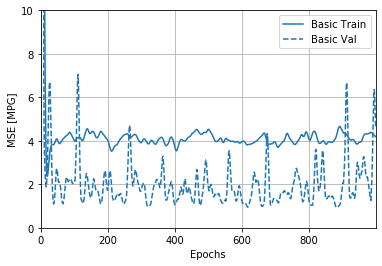

In [21]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 10])
plt.ylabel('MSE [MPG]')

In [ ]:
# For comparison perform linear regression with scikit learn
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True, normalize=False)
lin_model.fit(train.features, train.target)

# plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax[0].plot(test.target, prediction_values, "o", color="red", alpha=.5)
ax[1].plot(test.target, lin_model.predict(test.features), "o", color="blue", alpha=.5)
for i in [0,1]:
    ax[i].plot([0,10], [0,10], "--", lw=2, color="black")
    ax[i].set_xlabel("True value",  fontsize=15)
    ax[i].set_ylim(0,5.3)
    ax[i].set_xlim(0,5.3)
ax[0].set_ylabel("Predicted value (Tensorflow)", fontsize=15);
ax[1].set_ylabel("Predicted value (Scikit)",  fontsize=15);


# MSE on training set:
tf.reset_default_graph()
X = tf.constant(add_intercept(train.features), dtype=tf.float64, name="X")
theta = tf.constant(theta_value, dtype=tf.float64, name="theta")
prediction = tf.matmul(X, theta)
y_true = tf.constant(train.target, dtype=tf.float64, name="true_label")
y_pred_scikit = tf.constant(lin_model.predict(train.features), dtype=tf.float64, name="prediction_label")
mse = tf.reduce_mean(tf.square(y_true - prediction))
mse_scikit = tf.reduce_mean(tf.square(y_true - y_pred_scikit))
init = tf.global_variables_initializer()



# Linear Regression using the estimator API

# Linear Regression via an optimizier 
* Idea: use keras wit 1 layer, identitiy as activation function and logit as output node
* Assume that we could not find the minimizer analytically. 
* Thus we wish to find the minimzer computationally.

# Look at this:
* https://www.kdnuggets.com/2017/05/how-not-program-tensorflow-graph.html